# Future S.H.E.D: Space Heat Demand Profile Predictions with Machine Learning
## Authors:
* Cristiano Curi Fernandes - [University of Victoria](ww.uvic.ca)
## A project for the Institute for Integrated Energy Systems (IESVic) in fulfillement of the Technical Writing (ENGR 446) academic course

---------------------------------------------------------------------------------------------------------------------------------------------

## Objective
This is a neural network application, with the main task of predicting future space heat demand profiles for the province of British Columbia, based on data from the past

---------------------------------------------------------------------------------------------------------------------------------------------


# 1 Import Modules

In [1]:
# Data processing packages
import numpy as np # Numpy for mathematical operations
import pandas as pd # Pandas for data manipulation
import pandas_profiling # Profiling the data
import math

# Graphing libraries
import matplotlib.pyplot as plt # Matplotlib for visualization tasks
import plotly.express as px
import plotly.graph_objects as go


# Holt-Winter model
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose as sd # module for seasonal decomposition of the temperature profile
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Prophet model
from fbprophet import Prophet # Facebook Prophet forecaster library
from fbprophet.diagnostics import cross_validation

# LSTM model
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# Automated Linear Regression model
import torch
import torch.nn as nn
from sklearn import datasets



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2 Datasets and Data Curation

Preparing the dataset which will be used by the neural network. In this work  we are interested in the heat demand profiles for British Columbia, however, due to lack of available data for a similar climate zone, we'll be using [Norway's Statnett](https://www.ssb.no/en/statbank/table/11561) data for initial tests of the network and proff of concept stage

In [2]:
# Get data files
# Using Norway's energy demand data for initial tests and proof of concept stage of the project
input_data = pd.read_csv('/content/sample_data/test-norgeenergy1.csv', sep=',')
#input_data = pd.read_csv('C:\\Users\\crist\\OneDrive\\Documentos\\UVic\\Courses\\UVIC-2022\\Summer 2022\\ENGR 446\\Heating Demand Profiles\\test-norgeenergy1.csv', sep=',')

input_data.rename(columns={'Time':'Date_Time'}, inplace=True) # Renaming date/time column for better manipulation throughout the code
input_data.rename(columns={'Demand':'Demand'}, inplace=True)

# Convert date and time column into pandas date_time object - source: https://stackoverflow.com/questions/69658544/parsererror-hour-must-be-in-0-23-09-05-2019-2400
#input_data['Date_Time'] = (pd.to_datetime(input_data['Date_Time'].str.split(' ').str[0]) + pd.to_timedelta(input_data['Date_Time'].str.split(' ').str[3]))

input_data['Date_Time'] = pd.to_datetime(input_data['Date_Time'])

#input_data = input_data[input_data.Date_Time > pd.to_datetime(2010)]

input_data.drop_duplicates(subset='Date_Time', keep='last', inplace=True) # Eliminate duplicate surveys
input_data.sort_values(by='Date_Time')

#input_data['Temperature'] = (input_data['max_temperature'] + input_data['min_temperature'])/2 # Creating a temperature column to use as inputs

input_data.head()


,Date_Time,Demand,Temperature,Date,Holiday
0,2018-01-01 00:00:00,16989,5,01/01/2018,False
1,2018-01-01 01:00:00,16764,9,01/01/2018,False
2,2018-01-01 02:00:00,16509,1,01/01/2018,False
3,2018-01-01 03:00:00,16109,2,01/01/2018,False
4,2018-01-01 04:00:00,16152,6,01/01/2018,False


# 3 Building the Neural Network

In this step we begin creating the neural networ, but before training, let us  visualize the dataset we are dealing with

**IMPORTANT!!** this visualization step may vary depending on the input data, both in the output graphs and in the way these operations are to be carried out (depending on the structure of the `.csv` file)

This notebook will present a few different aapproaches for building the model. Here we construct the following models for energy demand forecasting:

* A [linear regression](https://www.deeplearningbook.org/contents/ml.html) model

* A [LSTM (Long Short-Term Memory)](https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2) network

* [Holt Winter's equaion](http://rstudio-pubs-static.s3.amazonaws.com/422208_46bbd2e18bbc472ea0d6c648cba1b694.html) for demand forecasting

**An important note on dates and time:** it is not useful to input dates and times into the neural network, as they do not contain meaningful insights to our output data on their own. Therefore, it is necessary to come up with a feature that can relate a date / time to the demand. For this, we shall use the temperature data. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



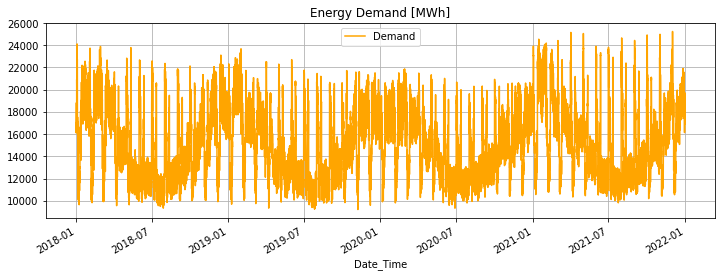

In [4]:
input_data['Demand'].interpolate(method='linear', inplace=True)

input_data.reindex(input_data.Date_Time)

#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/

# Visualizing data

input_data.plot(x='Date_Time',y='Demand',title='Energy Demand [MWh]',grid=True,c='orange',figsize=(12,4))


#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/

# Separating datasets

train_cutoff = pd.to_datetime('2019/12/31 23:00:00') # select data for last time step of the training data

timeframe = input_data
training_set = timeframe.loc[timeframe.Date_Time < train_cutoff, :] # Construct trainig set

testing_set = timeframe.loc[train_cutoff <= timeframe.Date_Time, :] # Construct testing set

#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/#/

# Creating weight vectors to extract numerical meaning from dates (relating demand to temperature)

train_temperatures = training_set['Temperature'] # Save temperatures to be used as input for the network (if Date_Time does not produce satisfactory results)

training_set.drop(training_set.columns.difference(['Date_Time','Demand']), 1, inplace=True) # Exclude unecessary columns from data

test_temperatures = testing_set['Temperature'] # Save temperatures to be used as input for the network (if Date_Time does not produce satisfactory results)

testing_set.drop(testing_set.columns.difference(['Date_Time','Demand']), 1, inplace=True) # Exclude unecessary columns from data


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3.1 Linear Regression

A noticible trend in the linear regression models is that the predictors are able to accurately capture the data's overall trend over time, but the scaling on the weight vector is out of proportions.

Investigating the best method for numerically representing dates in a machine learning model is crucial to the success of these models. A possible solution is to utilize temperature data to translate the date / time parameter into a numerical feature to be the network's input.

In [ ]:
from torch.nn.modules.linear import Linear
from numpy.core.fromnumeric import shape
from numpy.ma.core import ones

# Manually calculating the linear regression (NEEDS RECURSION TO BETTER APPROXIMATE RESULTS)
def Linear_Regression(x, y):
    # x: inputs to the model (vector of weighted temperatures agains demand)
    # y: outputs to the model (energy demand vector)
    # e: number of epochs for algorithm to run
    # w_hat: the vector of linear weights which is used to predict / forecast the outputs

    x_hat = np.array(list(x) + [1])

    X_big_hat = np.array([x, np.ones(len(x))]).transpose()

    w_hat = np.linalg.pinv(np.float64(X_big_hat)) * np.array(y) # Calculate the weights vector as the pseudo-inverse matrix of the model inputs

    print('\n weights: \n',w_hat, w_hat.shape)

    y_tilda = abs(w_hat[1,:]) * np.float64(x) + w_hat[0,:] #* np.float64(x) # Predicted outputs

    RMSE = np.sqrt(np.sum(np.square(y_tilda - y))/x_hat.shape) # Root-mean-square error
    
    return y_tilda, RMSE

test, error_test = Linear_Regression(train_temperatures.values.astype(np.float64()),training_set.Demand)

print('\n Prediction: \n', test, '\n Real value: ', training_set.Demand, '\n RMSE: ',error_test)

#test = test * 1e22

# Visualization
LR_figure = go.Figure()
LR_figure.add_trace(go.Scatter(x=training_set.index, y=test, mode='lines', name='Predicted Demands'))
LR_figure.add_trace(go.Scatter(x=training_set.index, y=training_set.Demand, mode='lines', name='Real Demands'))
LR_figure.update_layout(title='Linear Regression Prediction of Demands', xaxis_title='Date / Time', yaxis_title='Energy Demands [MWh]')
LR_figure.update_traces(line=dict(width=0.5))


In [ ]:
# Autonomous Linear Regression with PyTorch

x_lr, y_lr =  training_set.Date_Time, training_set.Demand #datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=1)
torch_x = torch.tensor(train_temperatures.values.astype(np.float64()))#training_set['Date_Time'].values.astype(np.float64())
torch_y = torch.tensor(training_set['Demand'].values.astype(np.float64()))

torch_y_normal = torch_y.view(torch_y.shape[0], 1)

lr_features = torch_x.shape

torch_lr_model = nn.Linear(lr_features[0], lr_features[0]) # Input the features and extract 1 output at a time

lr_loss = nn.MSELoss() # Pick error metric for linear regression
lr_loss_history = []
lr_optim = torch.optim.Adam(torch_lr_model.parameters(),lr=0.01) # Pick optimizer for linear regression (chose Adam optimizer at a learning rate of 0.01)
lr_epochs = 100 # More epochs give a lower loss (RMSE)

for ep in range(lr_epochs):
  # Forward pass
  torch_y_tilda = torch_lr_model(torch_x.float()) # Make a prediction
  curr_loss = lr_loss(torch_y_tilda, torch_y.float()) # Compare prediction to actual value
  lr_loss_history.append(torch.sqrt(curr_loss))
  # Backward pass
  curr_loss.backward()
  # Update input and weight vector
  lr_optim.step()
  #print('Optimization:', torch_y_tilda)
  lr_optim.zero_grad() # Avoid carrying unecessary information from one epoch to the next

lr_predictions = torch_lr_model(torch_x.float()).detach().numpy()

torch_RMSE = mean_squared_error(y_lr,lr_predictions, squared=False)
print('RMSE: ', torch_RMSE)


# Visualization
torch_figure = go.Figure()
torch_figure.add_trace(go.Scatter(x=training_set.index, y=lr_predictions, mode='lines', name='Predicted Demands')) # x = x_lr
torch_figure.add_trace(go.Scatter(x=training_set.index, y=y_lr, mode='lines', name='Real Demands')) # x = x_lr
torch_figure.update_layout(title='PyTorch Linear Regression', xaxis_title='Date / Time', yaxis_title='Energy Demands [MWh]')
torch_figure.update_traces(line=dict(width=0.5))



RMSE:  61.30666993820744


In [ ]:

# Testing Pytorch LR
testing_tensor = torch.tensor(test_temperatures.values.astype(np.float64()))

test_torch_predictions = torch_lr_model(testing_tensor[:len(torch_x)].float()).detach().numpy()

# Visualization
LR_test_figure = go.Figure()
LR_test_figure.add_trace(go.Scatter(x=testing_set.index, y=test_torch_predictions, mode='lines', name='Predicted Demands'))
LR_test_figure.add_trace(go.Scatter(x=testing_set.index, y=testing_set.Demand, mode='lines', name='Real Demands'))
LR_test_figure.update_layout(title='PyTorch Linear Regression - Test', xaxis_title='Date / Time', yaxis_title='Energy Demands [MWh]')
LR_test_figure.update_traces(line=dict(width=0.5))


## 3.2 LSTM Network

In [ ]:
# Scaling the data for the NN
my_scaler = MinMaxScaler() # Scaler to normalize demands (from 0 to 1 range)

training_set_copy = training_set.copy()
testing_set_copy = testing_set.copy()

training_set_copy.Date_Time = np.float64(training_set_copy.Date_Time)
testing_set_copy.Date_Time = np.float64(testing_set_copy.Date_Time)#.astype(float)#pd.to_numeric(testing_set.Date_Time)

my_scaler.fit(training_set_copy) # Apply scaler to training set
scaled_train = my_scaler.transform(training_set_copy)[:,1] # Get scaled demands for training
scaled_test = my_scaler.transform(testing_set_copy)[:,1] # Get scaled demands from test


[0.521926   0.5068162  0.48969176 0.4628299  0.46571755 0.46927674
 0.49358673 0.51373313 0.53441676 0.55093681]


In [ ]:
# Establish LSTM parameters
nn_inputs = 168 # give the nn X hours as the input
nn_features = 1 # number of features being analysed by the network (just the demand in our case)

# Create timeseries
lstm_timeseries = TimeseriesGenerator(scaled_train, scaled_train, length=nn_inputs, batch_size=1) # Generate timeseries from training set 

# Create neural network
my_lstm = Sequential() # Create the neural network as an LSTM sequential model
my_lstm.add(LSTM(100, activation='relu', input_shape=(nn_inputs,nn_features))) # Create the LSTM (RNN) with 100 neurons and using the Relu function at the activation layer
my_lstm.add(Dense(1)) # Add prediction (output) layer to the network

# Solve model with Adam optimization technique and RMS error as metric for loss, then print results
my_lstm.compile(optimizer='adam', loss='mse') 
my_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
17351/17351 [==============================] - 1111s 64ms/step - loss: 0.0013
Epoch 2/10
17351/17351 [==============================] - 1111s 64ms/step - loss: 3.2799e-04
Epoch 3/10
17351/17351 [==============================] - 1105s 64ms/step - loss: 2.7562e-04
Epoch 4/10
17351/17351 [==============================] - 1096s 63ms/step - loss: 2.6518e-04
Epoch 5/10
17351/17351 [==============================] - 1116s 64ms/step - loss: 2.3850e-04
Epoch 6/10
17351/17351 [==============================] - 1096s 63ms/step - loss: 2.2570e-04
Epoch 7/10
17351/17351 [==============================] - 1121s 65ms/step - loss: 2.1813e-04
Epoch 8/10
17351/17351 [==============================] - 1110s 64ms/step - loss: 2.1412e-04
Epoch 9/10
17351/17351 [==============================] - 1099s 63ms/step - loss: 2.0854e-04
Epoch 10/10
17351/17351 [==============================] - 1121s 65ms/step - loss: 2.0022e-04


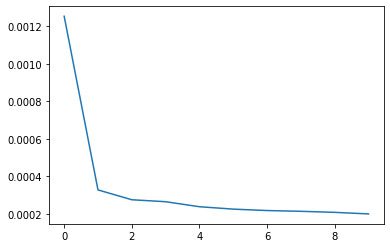

In [ ]:
# Train LSTM model with generated time series and 50 epochs
my_lstm.fit(lstm_timeseries, epochs=10)
epoch_loss = my_lstm.history.history['loss'] # Get loss per epoch
plt.plot(range(len(epoch_loss)), epoch_loss)

In [ ]:
from IPython.core.pylabtools import figsize
# Testing the model and getting results

prediction_batch = scaled_train[-nn_inputs:]
prediction_batch = prediction_batch.reshape((1,nn_inputs, nn_features))
lstm_pred = my_lstm.predict(prediction_batch) # Make prediction

print("Real Value:\t Predicted value: \n", scaled_test[0], "\t", lstm_pred)

current_batch = prediction_batch
model_predictions = []
for b in range(nn_inputs):#range(len(testing_set)):
  curr_pred = my_lstm.predict(current_batch).reshape(-1,1)[0].tolist()
  model_predictions.append(curr_pred[0])
  current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

model_predictions = np.array(model_predictions)
model_predictions = model_predictions.reshape(-1,2)
true_predictions = my_scaler.inverse_transform(model_predictions)

# Visualization
LSTM_figure = go.Figure()
LSTM_figure.add_trace(go.Scatter(x=training_set.Date_Time[:72], y=true_predictions[:,1], mode='lines', name='Predicted Demands')) # training_set.Date_Time[:72]
LSTM_figure.add_trace(go.Scatter(x=training_set.Date_Time[:72], y=training_set.Demand[:72], mode='lines', name='Real Demands')) # training_set.Date_Time[:72]
LSTM_figure.update_layout(title='LSTM Prediction of Demands', xaxis_title='Date / Time', yaxis_title='Energy Demands [MWh]')
LSTM_figure.update_traces(line=dict(width=0.5))

Real Value:	 Predicted value: 
 0.46759787791283336 	 [[0.04146014]]
All predictions: 
 [0.04146013781428337, 0.034036800265312195, 0.028017017990350723, 0.02312120795249939, 0.019035056233406067, 0.015605618245899677, 0.012734195217490196, 0.01035438384860754, 0.00838773138821125, 0.006757345516234636, 0.005412414204329252, 0.00431154016405344, 0.003416001796722412, 0.0026931501924991608, 0.0021135995630174875, 0.0016524189850315452, 0.0012879158603027463, 0.0010011153062805533, 0.0007761662709526718, 0.0006003732560202479, 0.0004634457000065595, 0.00035712463431991637, 0.00027486789622344077, 0.000211406106245704, 0.00016270417836494744, 0.00012539236922748387, 9.676750778453425e-05, 7.483750960091129e-05, 5.798777419840917e-05, 4.503252057475038e-05, 3.5099685192108154e-05, 2.74264530162327e-05, 2.1449124687933363e-05, 1.6766196495154873e-05, 1.3101879630994517e-05, 1.0232827662548516e-05, 7.985672709764913e-06, 6.235104592633434e-06, 4.869141775998287e-06, 3.7987190353305778e-06, 2

In [ ]:
# Calculate network error

lstm_rmse = mean_squared_error(testing_set.Demand[:84], true_predictions[:,1], squared=False)

print('LSTM RMSE: ', lstm_rmse)

LSTM RMSE:  8102.67074051048


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3.3 Holt-Winter Forecasting [2]


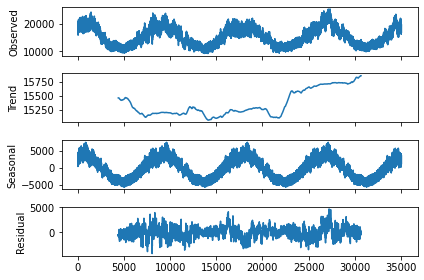

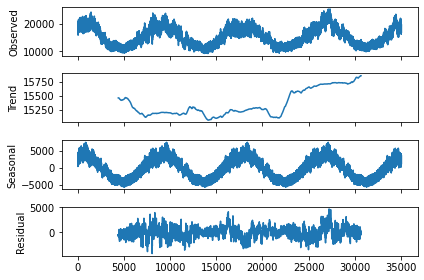

In [ ]:
# Seasonal decomposition of data:

seasonal_demand = sd(input_data['Demand'], model='additive', freq=24*365)
seasonal_demand.plot()

In [ ]:
# Using statsmodel library to apply the Holt-Winter seasonality equation

HW_train, HW_test =  training_set['Demand'], testing_set['Demand'] #training_set.Demand, testing_set.Demand

Holt_Winter = ExponentialSmoothing(HW_train, seasonal_periods=24*365, seasonal='add').fit()

HW_prediction = Holt_Winter.forecast(len(testing_set['Demand']))



In [ ]:
# Visualization 
HW_figure = go.Figure()
HW_figure.add_trace(go.Scatter(x=testing_set.index, y=HW_prediction, mode='lines', name='Holt-Winters Predicted Demands'))
HW_figure.add_trace(go.Scatter(x=testing_set.index, y=testing_set['Demand'], mode='lines', name='Ground Truth Demands'))
HW_figure.update_layout(title='Holt-Winters Forecast of Demands', xaxis_title='Date / Time', yaxis_title='Energy Demands [MWh]')
HW_figure.update_traces(line=dict(width=1))

In [ ]:
# Error metrics for Holts-Winter

HW_RMSE = mean_squared_error(HW_test, HW_prediction, squared=False)
print("Holt-Winters RMSE: ", HW_RMSE)

Holt-Winters RMSE:  1696.969788349221


## 3.4 Prophet model


This forecasting method can give the engineer a perspective on the general trend of the data for future dates,for which data is currently unavailable

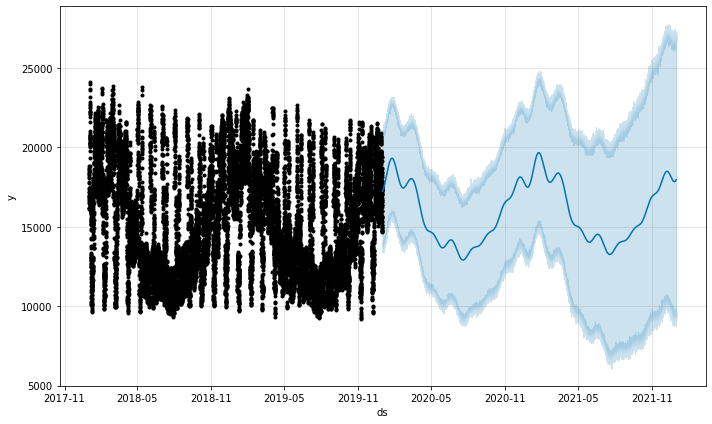

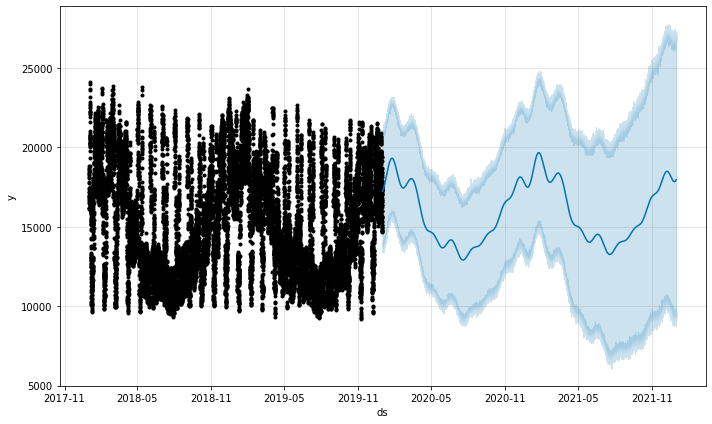

In [ ]:
from pandas.plotting import register_matplotlib_converters

training_prophet = training_set.reset_index().rename(columns={'Date_Time' : 'ds', 'Demand' : 'y'})
testing_prophet = testing_set.reset_index().rename(columns={'Date_Time' : 'ds', 'Demand' : 'y'})

# Model the data using Facebook's prophet
data_prophet = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
data_prophet.fit(training_prophet)

# Forecast
future_demand = testing_prophet.drop(['y'], axis=1)
prophet_forecast = data_prophet.predict(future_demand)
#print(testing_set)

# See results
register_matplotlib_converters()
Prophet.plot(data_prophet, prophet_forecast) # Plot modeled (for training set) data and future data (prediction on testing set)


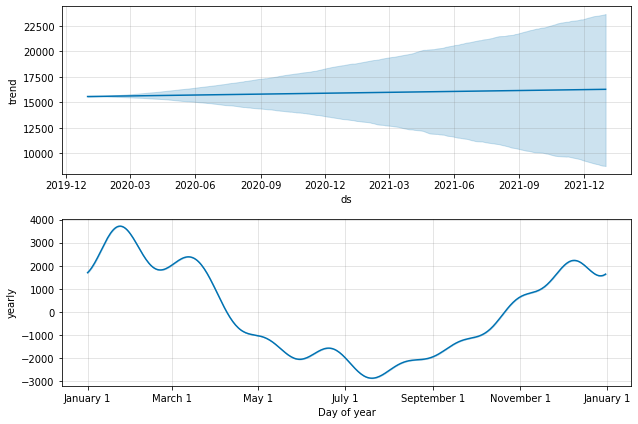

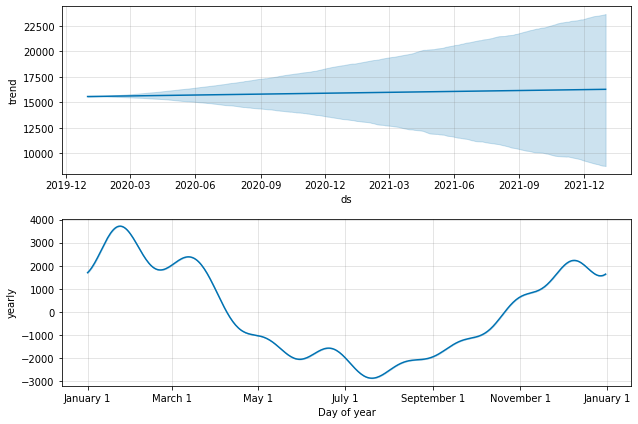

In [ ]:
data_prophet.plot_components(prophet_forecast) # Plot predicted yearly trend / year-long seasonal variations 

# References

## Different models

[1] [Forecasting Norwegian Energy Demand with Python; Jason Deegan](https://jasondeegan.com/forecasting-norwegian-energy-demand-with-python/)

[2] [Forecasting Energy Demand (Python Hourly Energy Consumption) - Kaggle; Robin Teuwens](https://www.kaggle.com/code/robinteuwens/forecasting-energy-demand/notebook)


[3] [Energy consumption time series forecasting with python and LSTM deep learning model - Medium; Eligijus Bujokas](https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796)

[4] [Predicting Hourly Energy consumption of San Diego — I - Medium; Pratha Pawar](https://towardsdatascience.com/part-1-time-series-analysis-predicting-hourly-energy-consumption-of-san-diego-short-term-long-3a1dd1a589c9)

[5] [Predicting Hourly Energy consumption of San Diego — II - Medium; Pratha Pawar](https://towardsdatascience.com/part-2-time-series-analysis-predicting-hourly-energy-consumption-of-san-diego-ii-f09665796c9)

[6] [Energy Consumption Prediction with Machine Learning; Aman Kharwal](https://thecleverprogrammer.com/2021/01/23/energy-consumption-prediction-with-machine-learning/)

[7] [R. S. Broujeny, K. Madani, A. Chebira, V. Amarger and L. Hurtard, "A Machine-Learning Based Approach for Data-Driven Identification of Heating Dynamics of Buildings' Living-Spaces," 2019 10th IEEE International Conference on Intelligent Data Acquisition and Advanced Computing Systems: Technology and Applications (IDAACS), 2019, pp. 197-202, doi: 10.1109/IDAACS.2019.8924329.](https://ieeexplore.ieee.org/document/8924329)

[8] [Machine Learning For Energy Consumption Prediction and Scheduling in Smart Buildings](https://link.springer.com/content/pdf/10.1007/s42452-020-2024-9.pdf)

[9] [A. T. Eseye and M. Lehtonen, "Short-Term Forecasting of Heat Demand of Buildings for Efficient and Optimal Energy Management Based on Integrated Machine Learning Models," in IEEE Transactions on Industrial Informatics, vol. 16, no. 12, pp. 7743-7755, Dec. 2020, doi: 10.1109/TII.2020.2970165.](https://ieeexplore.ieee.org/document/8990012)

[10] [Time-series Extreme Event Forecasting with Neural Networks at Uber](http://roseyu.com/time-series-workshop/submissions/TSW2017_paper_3.pdf)

[11] [Time Series forecasting with Prophet](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet)

## Different energy demand datasets

[12] [Hourly Energy Consumption; Rob Mulla](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

[13] [Norway's Statnett](https://www.ssb.no/en/statbank/table/11561)

[14] [Brazil's Energy Dataset (PORTUGUESE)](https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/Documents/CONSUMO%20MENSAL%20DE%20ENERGIA%20EL%C3%89TRICA%20POR%20CLASSE.xls)